In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import normal
from numpy.linalg import norm
from scipy.stats import beta
from scipy.special import digamma
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, root_mean_squared_error, r2_score
from sklearn.linear_model import SGDRegressor

from RMSProp import SGD_RMSProp
from BetaRegression import *

# Проверка SGD RMSProp на данных в модели бета-регрессии 

In [2]:
df = pd.read_csv("./Data/observations.csv", sep=";").drop("Cover_class", axis = 1)
df.head()

,Site_id,Visit_id,Species_id,Cover
0,4,6345,2338,2
1,4,16199,2338,3
2,4,28382,2338,3
3,4,40703,2338,2
4,4,49283,2338,1


In [3]:
X, y = df.drop("Cover", axis=1), df["Cover"] / 100
colnames = df.columns.to_list()
nrow, ncol = X.shape

### Стандартизация данных

In [4]:
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train_ones = np.hstack([X_train_s, np.ones((y_train.size, 1))])
X_test_ones = np.hstack([X_test_s, np.ones((y_test.size, 1))])

np.savetxt(
    "./Data/train.csv",
    np.hstack([X_train_s, y_train.to_numpy().reshape((y_train.size, 1))]),
    comments="",
    delimiter=",",
    header=",".join(colnames),
)
np.savetxt(
    "./Data/test.csv",
    np.hstack([X_test_s, y_test.to_numpy().reshape(y_test.size, 1)]),
    comments="",
    delimiter=",",
    header=",".join(colnames),
)

### Бета-регрессия:

In [5]:
%%time

np.random.seed(42)

mean_y_train = y_train.mean()
phi_y_train = (mean_y_train * (1 - mean_y_train)) / y_train.var() - 1

beta_start = normal(0, 1, 4)
phi_start = phi_y_train
start_point = np.append(beta_start, phi_start)

beta_res = SGD_RMSProp(
    start=start_point,
    X=X_train_ones,
    y=y_train.to_numpy(),
    L_grad=beta_illh_grad,
    L=beta_inv_log_likelihood,
    batch_size=100,
    use_epoch = True,
    learning_rate=0.01,
    decay_rate=0.9,
    max_iter=5000,
    tol=1e-8,
    link_inverse=logit_inverse,
    link_deriv=logit_deriv,
)

CPU times: user 330 ms, sys: 1.93 ms, total: 331 ms
Wall time: 336 ms


In [6]:
beta_coef_est = beta_res["point"][:-1]
beta_phi_est = beta_res["point"][-1]
beta_loss = beta_res["L_value"]

print(f"""
coef: {beta_coef_est}
phi: {beta_phi_est}
loss function value: {beta_loss}
iteratons: {beta_res["iterations"]}""")


coef: [ 5.07145189e-03 -1.18579454e-03 -2.44834722e-01 -1.69638061e+00]
phi: 3.2234246308237164
loss function value: -4694.936478948099
iteratons: 3652


### Коэффициенты и минус логарифм функции правдоподобия для них, полученные функцией `betareg` в R
Параметры оптимизации в `betareg` взяты по умолчанию.

In [7]:
betareg_params = np.loadtxt("betareg_res.dat", delimiter=" ", unpack=False)
betareg_coef_est = betareg_params[:-1]
betareg_phi_est = betareg_params[-1]
betareg_loss = beta_inv_log_likelihood(betareg_params, X_train_ones, y_train, link_inverse=logit_inverse)

print(f"""coef: {betareg_coef_est}
phi: {betareg_phi_est}
loss function value: {betareg_loss}""")

coef: [ 0.00422392 -0.00911975 -0.2439333  -1.668232  ]
phi: 3.152048
loss function value: -4693.874211280123


### Линейная регрессия

In [8]:
def linear_loss(w, X, y):
    return norm(X.dot(w) - y) ** 2 / y.size


def linear_loss_grad(w, X, y):
    return 2 * X.T.dot(X.dot(w) - y) / y.size

In [9]:
np.random.seed(42)

start_point_linear = normal(0, 1, 4)

linear_res = SGD_RMSProp(
    start=start_point_linear,
    X=X_train_ones,
    y=y_train.to_numpy(),
    L_grad=linear_loss_grad,
    L=linear_loss,
    batch_size=0.1,
    use_epoch = True,
    learning_rate=0.01,
    decay_rate=0.9,
    max_iter=1000,
    tol=1e-7
)

my_lin_coef_est = linear_res["point"]

print(f"""
coef: {my_lin_coef_est[:-1]}
intercept: {my_lin_coef_est[-1]}
loss function value: {linear_res["L_value"]}
iteratons: {linear_res["iterations"]}""")


coef: [ 0.00199334  0.00013956 -0.06366348]
intercept: 0.13845756109721372
loss function value: 0.03973629802238174
iteratons: 473


### Линейная регрессия из библиотеки `sklearn`

In [10]:
sk_lin_model = SGDRegressor(alpha=0, learning_rate="adaptive", eta0=0.01, max_iter=1000, tol=1e-7, random_state=42)
sk_lin_model.fit(X_train_s, y_train)

sk_lin_loss = linear_loss(np.append(sk_lin_model.coef_, sk_lin_model.intercept_), X_train_ones, y_train)
sk_lin_coef_est = np.append(sk_lin_model.coef_, sk_lin_model.intercept_[0])
print(f"""
coef: {sk_lin_coef_est[:-1]}
intercept: {sk_lin_coef_est[-1]}
loss function value: {sk_lin_loss}""")


coef: [ 0.00182775 -0.0001474  -0.06406937]
intercept: 0.13737261573129636
loss function value: 0.039734865602112576


## Проверка качества моделей

### Метрики:
0.  **$\boldsymbol{R^2}$**

0. **BIC**:
    $$ \mathrm{BIC} = k \log(n) - 2 \log(L_m), $$
    где $k$ - число оценённых параметров модели, $n$ - число индивидов, на которых 
    тренировалась модель, $L_m$ - функция правдоподобия модели.

0.  **RMSE**:
    $$\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - y_i^*)^2}, $$
    где $y_i$ - значение признака, $y_i^*$ - его предсказание по модели.

In [11]:
# Предсказания моделей на тренировочной выборке
beta_means_pred_train = logit_inverse(X_train_ones, beta_coef_est)
betareg_means_pred_train = logit_inverse(X_train_ones, betareg_coef_est)
sk_lin_pred_train = sk_lin_model.predict(X_train_s)
my_lin_pred_train = X_train_ones.dot(my_lin_coef_est)

# Предсказания моделей на тестовой выборке
beta_means_pred_test = logit_inverse(X_test_ones, beta_coef_est)
betareg_means_pred_test = logit_inverse(X_test_ones, betareg_coef_est)
sk_lin_pred_test = sk_lin_model.predict(X_test_s)
my_lin_pred_test = X_test_ones.dot(my_lin_coef_est)

# Предсказания дисперсий на тренировочной выборки для моделей бета-регрессии
beta_var_pred_train = beta_means_pred_train * (1 - beta_means_pred_train) / (1 + beta_phi_est)
betareg_var_pred_train = betareg_means_pred_train * (1 - betareg_means_pred_train) / (1 + betareg_phi_est)

# Предсказания дисперсий на тестовой выборки для моделей бета-регрессии
beta_var_pred_test = beta_means_pred_test * (1 - beta_means_pred_test) / (1 + beta_phi_est)
betareg_var_pred_test = betareg_means_pred_test * (1 - betareg_means_pred_test) / (1 + betareg_phi_est)


### $R^2$

In [12]:
print(f"""On train data
My linear model: R^2 = {r2_score(y_train, my_lin_pred_train)}
Sklearn linear model: R^2 = {r2_score(y_train, sk_lin_pred_train)}
My beta regression model: R^2 = {r2_score(y_train, beta_means_pred_train)}
R beta regression model: R^2 = {r2_score(y_train, betareg_means_pred_train)}
\nOn test data
My linear model: R^2 = {r2_score(y_test, my_lin_pred_test)}
Sklearn linear model: R^2 = {r2_score(y_test, sk_lin_pred_test)}
My beta regression model: R^2 = {r2_score(y_test, beta_means_pred_test)}
R beta regression model: R^2 = {r2_score(y_test, betareg_means_pred_test)}""")

On train data
My linear model: R^2 = 0.09439019528454273
Sklearn linear model: R^2 = 0.09442284084803865
My beta regression model: R^2 = 0.05815304765210738
R beta regression model: R^2 = 0.05511436981457207

On test data
My linear model: R^2 = 0.0944780291202536
Sklearn linear model: R^2 = 0.09432311468456755
My beta regression model: R^2 = 0.06113140899528602
R beta regression model: R^2 = 0.058724747087445794


### BIC

In [14]:
def linear_log_likelihood(y_pred, y_test, k):
    n = y_pred.size
    sse = np.sum((y_pred - y_test) ** 2)
    s2 = sse / (n - k)
    return -n / 2 * np.log(2 * np.pi) - n / 2 * np.log(s2) - sse / (2 * s2)

In [15]:
train_n = X_train.shape[0]
test_n = X_test.shape[0]

lin_k = my_lin_coef_est.size + 1
beta_k = beta_res["point"].size

my_lin_bic_train = lin_k * np.log(train_n) - 2 * linear_log_likelihood(X_train_ones.dot(my_lin_coef_est), y_train, lin_k)
sk_lin_bic_train = lin_k * np.log(train_n) - 2 * linear_log_likelihood(X_train_ones.dot(sk_lin_coef_est), y_train, lin_k)
beta_bic_train = beta_k * np.log(train_n) + 2 * beta_loss
betareg_bic_train = beta_k * np.log(train_n) + 2 * betareg_loss
print(f"""On train data
My linear model: BIC = {my_lin_bic_train}
Sklearn linear model: BIC = {sk_lin_bic_train}
My beta regression: BIC = {beta_bic_train}
R beta regression: BIC = {betareg_bic_train}
""")

my_lin_bic_test = lin_k * np.log(test_n) - 2 * linear_log_likelihood(X_test_ones.dot(my_lin_coef_est), y_test, lin_k)
sk_lin_bic_test = lin_k * np.log(test_n) - 2 * linear_log_likelihood(X_test_ones.dot(sk_lin_coef_est), y_test, lin_k)
beta_bic_test = beta_k * np.log(test_n) + 2 * beta_inv_log_likelihood(beta_res["point"], X_test_ones, y_test, logit_inverse)
betareg_bic_test = beta_k * np.log(test_n) + 2 * beta_inv_log_likelihood(betareg_params, X_test_ones, y_test, logit_inverse)

print(f"""\nOn test data
My linear model: BIC = {my_lin_bic_test}
Sklearn linear model: BIC = {sk_lin_bic_test}
My beta regression: BIC = {beta_bic_test}
R beta regression: BIC = {betareg_bic_test}""")

On train data
My linear model: BIC = -1657.7510184970834
Sklearn linear model: BIC = -1657.9090925102028
My beta regression: BIC = -9347.943233372165
R beta regression: BIC = -9345.818698036213


On test data
My linear model: BIC = -744.5652646998458
Sklearn linear model: BIC = -744.1955978405847
My beta regression: BIC = -4499.347695369185
R beta regression: BIC = -4500.50457601093


### RMSE

In [16]:
print(f"""On train data
My linear model: RMSE = {root_mean_squared_error(y_train, my_lin_pred_train)}
Sklearn linear model: RMSE = {root_mean_squared_error(y_train, sk_lin_pred_train)}
My beta regression: RMSE = {root_mean_squared_error(y_train, beta_means_pred_train)}
R beta regression: RMSE = {root_mean_squared_error(y_train, betareg_means_pred_train)}
\nOn test data
My linear model: RMSE = {root_mean_squared_error(y_test, my_lin_pred_test)}
Sklearn linear model: RMSE = {root_mean_squared_error(y_test, sk_lin_pred_test)}
My beta regression: RMSE = {root_mean_squared_error(y_test, beta_means_pred_test)}
R beta regression: RMSE = {root_mean_squared_error(y_test, betareg_means_pred_test)}""")

On train data
My linear model: RMSE = 0.19933965491688202
Sklearn linear model: RMSE = 0.19933606197101542
My beta regression: RMSE = 0.2032887346262716
R beta regression: RMSE = 0.20361640544840412

On test data
My linear model: RMSE = 0.20187713133401008
Sklearn linear model: RMSE = 0.20189439891306546
My beta regression: RMSE = 0.2055606744303
R beta regression: RMSE = 0.2058239692202449


### Распределение остатков Пирсона модели бета регрессии на тестовой выборке (стандартизованы с учётом гетероскедастичности)

In [30]:
beta_resids = y_test - beta_means_pred_test
beta_resids_pearson = beta_resids / np.sqrt(beta_var_pred_test)

print(f"""Mean of residuals: {beta_resids_pearson.mean()}
Variance of residuals: {beta_resids_pearson.var()}
Quantiles of residuals: {np.quantile(beta_resids_pearson, [0, 0.25, 0.5, 0.75, 1])}""")

Mean of residuals: -0.11337939991032248
Variance of residuals: 1.2549317333340915
Quantiles of residuals: [-0.90229075 -0.83821511 -0.57767217  0.02081175  4.23086114]


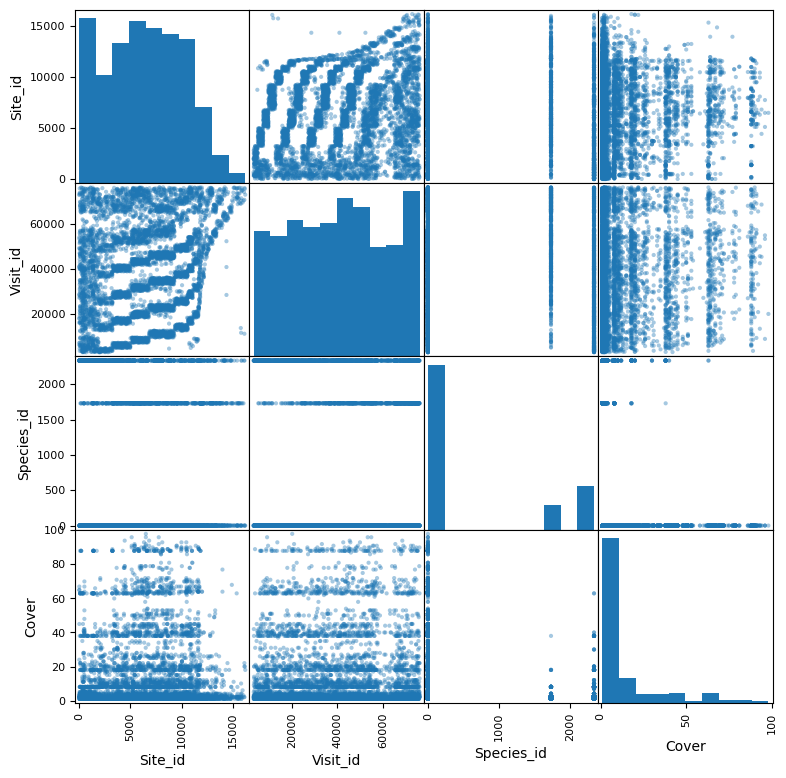

In [41]:
pd.plotting.scatter_matrix(df, alpha = 0.4, figsize = (9, 9));